# Lab: Using a pre-trained model
We will use a pre-trained model to classify cats-and-dogs!

### Runtime
~ 30 minutes

### Note
Here we are dealing with real world images.  Processing them will required a lot of compute power.  
If you have access to, switch to **GPU** as run time!

### References
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
tf.config.experimental.list_physical_devices()

tensorflow version : 2.2.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
## Add top level dir to include path
import os
import sys
from pathlib import Path

top_dir = os.path.abspath(Path(os.getcwd()).parent)
if top_dir not in sys.path:
    sys.path.append(top_dir)

## TF-GPU Config
The following cell sets TF properties to run on GPU

In [3]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1 - Download Data
We will use cat-dog-redux dataset

In [4]:
## Common constants

IMG_WIDTH=160
IMG_HEIGHT=160
NUM_CLASSES=2
BATCH_SIZE=64

In [5]:
import os

data_location = 'https://elephantscale-public.s3.amazonaws.com/data/images/cat-dog-redux.zip'

data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
                                           origin=data_location, extract=True)
print ('local download file: ', data_location_local)
data_dir = os.path.join(os.path.dirname(data_location_local), 'cat-dog-redux')
print ('local data dir: ', data_dir)
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
print ('train dir:', train_dir)
print ('validation dir:', validation_dir)

local download file:  /home/sujee/.keras/datasets/cat-dog-redux.zip
local data dir:  /home/sujee/.keras/datasets/cat-dog-redux
train dir: /home/sujee/.keras/datasets/cat-dog-redux/train
validation dir: /home/sujee/.keras/datasets/cat-dog-redux/val


## Step 2 - Download MobileNetv2 Model
Here we will examine MobileNetv2 model.  MobileNetv2 was developed at Google.  It is pre-trained on the ImageNet dataset consisting of 1.4 Million images and 1000 classes.

- paper: [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861)
- [github](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md)
- [Tensorflow model page](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)
- [Tensorflow transfer learning guide](https://www.tensorflow.org/tutorials/images/transfer_learning)

#### Notice the following:
- To use the MobileNet model, input image dimension should be one of (w,w,3)  
Image widths are one of 96, 128, 160, 192, 224(default).  
We are using 160 as that is closest to our images
- We are also initializing the model with the weights of 'imagenet'
- We are importing the full model (including the classifiying layer)


In [15]:
from transfer_learning_utils import print_model_summary_compact

mobilenetv2_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), 
                                               include_top = True,
                                               weights = 'imagenet')
print_model_summary_compact(mobilenetv2_model)

# ! du -skh ~/.keras/models/*

* Model: "mobilenetv2_1.00_224"
* Total params: 3,538,984
* Trainable params: 3,504,872
* Non-trainable params: 34,112
* # layers:  157
36K	/home/sujee/.keras/models/imagenet_class_index.json
92M	/home/sujee/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5
14M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5
9.0M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5
14M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5
9.0M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
232M	/home/sujee/.keras/models/resnet152v2_weights_tf_dim_ordering_tf_kernels.h5


## Step 3 - Predict on a Single Image

In [7]:
def predict_on_single_image(image_file, model, model_pkg):
    from tensorflow.keras.preprocessing.image import load_img
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.preprocessing.image import img_to_array
    import os
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    print ("image_file:", image_file)
    img = image.load_img(image_file, target_size = (IMG_WIDTH, IMG_HEIGHT))
    # print ("image size: " , img.size)
    
    # scale the data
    img_data = image.img_to_array(img)
    # img_data = img_data / 255.0
    # print ('image_data.shape:', img_data.shape)
    
    ## The networks accept a 4-dimensional Tensor as an input of the form 
    ## ( batchsize, height, width, channels).
    img_data = np.expand_dims(img_data, axis = 0)
    # print('image_data converted to tensor form (batchsize, height, width, channels):', img_data.shape)
    
    ## Preprocess the input by subtracting the mean value from each channel of the images in the batch. 
    ## Mean is an array of three elements obtained by the average of R, G, B pixels of all images obtained from ImageNet. 
    ## The values for ImageNet are : [ 103.939, 116.779, 123.68 ]. 
    ## This is done using the preprocess_input() function.
    ## Using a copy here, because the function modifies the array
    processed_image = model_pkg.preprocess_input(img_data.copy())
    # print ('processed_image.shape:', processed_image.shape)

    ## Finally ready to prodict
    ## prediction will be a 1000 wide softmax array!
    ## Remember, ImageNet has 1000 classes
    prediction = model.predict (processed_image)
    # prediction = mobilenetv2_model.predict (img_data)
    # print ('prediction.shape:', prediction.shape)

    ## pull the highest probability from softmax output
    predictions2 = [ np.argmax(p) for p in prediction]
    index_of_highest_probability = np.argmax(prediction[0])
    value_of_highest_probability = prediction[0][index_of_highest_probability]
    print ("predicted class: ", index_of_highest_probability, ", probability:", value_of_highest_probability)
    
    
    ## This tells us a little about prediction
    decoded_predictions = model_pkg.decode_predictions(prediction)

    ## Here we are using a pandas dataframe to pretty-print top-5
    print ("Top-5 predictions:")
    df = pd.DataFrame(columns=['Class Id', 'Description', 'Probability (high to low)'])
    for i, p in enumerate(decoded_predictions[0]):
        # print ("    ", i, p)
        df.loc[i] = (p[0], p[1], p[2])

    ## plot the image
    # plt.figure()  # stack images vertically
    print(df)
    plt.imshow(img)
    plt.show()


## End: predict_on_single_image

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.11283.jpg
predicted class:  281 , probability: 0.5209749
Top-5 predictions:
    Class Id   Description  Probability (high to low)
0  n02123045         tabby                   0.520975
1  n02124075  Egyptian_cat                   0.136530
2  n02123159     tiger_cat                   0.135872
3  n02123394   Persian_cat                   0.012930
4  n02127052          lynx                   0.009831


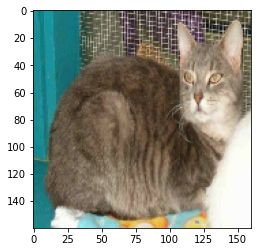

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.9372.jpg
predicted class:  162 , probability: 0.49582803
Top-5 predictions:
    Class Id         Description  Probability (high to low)
0  n02088364              beagle                   0.495828
1  n02088238              basset                   0.332110
2  n02089867        Walker_hound                   0.078867
3  n02099712  Labrador_retriever                   0.008504
4  n02089973    English_foxhound                   0.007416


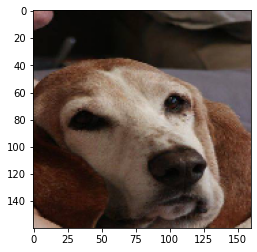

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.4656.jpg
predicted class:  285 , probability: 0.43937513
Top-5 predictions:
    Class Id   Description  Probability (high to low)
0  n02124075  Egyptian_cat                   0.439375
1  n02123045         tabby                   0.172389
2  n02123159     tiger_cat                   0.037131
3  n04493381           tub                   0.014785
4  n02870880      bookcase                   0.013028


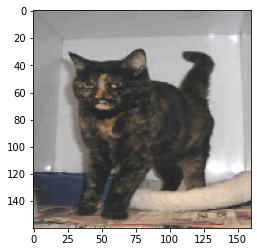

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.7695.jpg
predicted class:  196 , probability: 0.40929383
Top-5 predictions:
    Class Id           Description  Probability (high to low)
0  n02097047   miniature_schnauzer                   0.409294
1  n02097209    standard_schnauzer                   0.115950
2  n02113624            toy_poodle                   0.033364
3  n02102040      English_springer                   0.023083
4  n02105641  Old_English_sheepdog                   0.021279


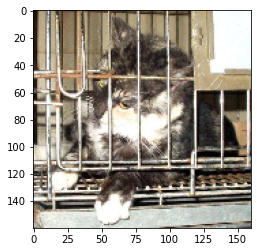

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.8733.jpg
predicted class:  179 , probability: 0.2934489
Top-5 predictions:
    Class Id                     Description  Probability (high to low)
0  n02093256       Staffordshire_bullterrier                   0.293449
1  n02093428  American_Staffordshire_terrier                   0.159313
2  n02099712              Labrador_retriever                   0.108791
3  n02115641                           dingo                   0.047763
4  n02087394             Rhodesian_ridgeback                   0.041627


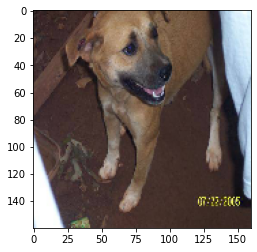

In [8]:
import random
from image_utils import get_image_files_from_dir

image_files = get_image_files_from_dir(validation_dir, recursive=True)
# print (image_files)

for i in range(5):
    # get a random image
    index = random.randint(0, len(image_files)-1)
    image_file = image_files[index]
    predict_on_single_image(image_file, mobilenetv2_model, tf.keras.applications.mobilenet)
    print ('============================================================================')
    

## ===================================================

## Step 4 - Inception Model

In [16]:
IMG_WIDTH=299
IMG_HEIGHT=299

from transfer_learning_utils import print_model_summary_compact

inceptionv3_model = tf.keras.applications.InceptionV3(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), 
                                               include_top = True,
                                               weights = 'imagenet')
print_model_summary_compact(inceptionv3_model)

# ! du -skh ~/.keras/models/*

* Model: "inception_v3"
* Total params: 23,851,784
* Trainable params: 23,817,352
* Non-trainable params: 34,432
* # layers:  313
36K	/home/sujee/.keras/models/imagenet_class_index.json
92M	/home/sujee/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5
14M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5
9.0M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5
14M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5
9.0M	/home/sujee/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
232M	/home/sujee/.keras/models/resnet152v2_weights_tf_dim_ordering_tf_kernels.h5


image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.8733.jpg
predicted class:  180 , probability: 0.44402626
Top-5 predictions:
    Class Id                     Description  Probability (high to low)
0  n02093428  American_Staffordshire_terrier                   0.444026
1  n02093256       Staffordshire_bullterrier                   0.390196
2  n02108422                    bull_mastiff                   0.024974
3  n02087394             Rhodesian_ridgeback                   0.012716
4  n02115641                           dingo                   0.008343


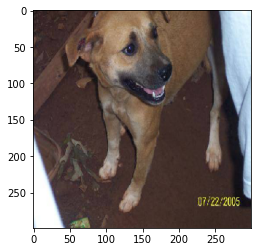

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.4009.jpg
predicted class:  284 , probability: 0.989312
Top-5 predictions:
    Class Id   Description  Probability (high to low)
0  n02123597   Siamese_cat                   0.989312
1  n02127052          lynx                   0.001900
2  n02124075  Egyptian_cat                   0.000669
3  n02441942        weasel                   0.000569
4  n02125311        cougar                   0.000385


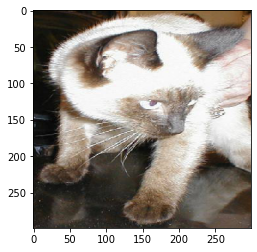

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.5472.jpg
predicted class:  185 , probability: 0.4484701
Top-5 predictions:
    Class Id              Description  Probability (high to low)
0  n02094114          Norfolk_terrier                   0.448470
1  n02093754           Border_terrier                   0.286626
2  n02095570         Lakeland_terrier                   0.109160
3  n02093991            Irish_terrier                   0.028964
4  n02095314  wire-haired_fox_terrier                   0.010617


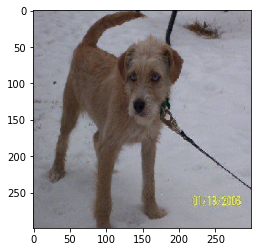

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.2039.jpg
predicted class:  273 , probability: 0.18333238
Top-5 predictions:
    Class Id      Description  Probability (high to low)
0  n02115641            dingo                   0.183332
1  n02109961       Eskimo_dog                   0.138134
2  n02114548       white_wolf                   0.133320
3  n02110185   Siberian_husky                   0.114638
4  n02106662  German_shepherd                   0.095230


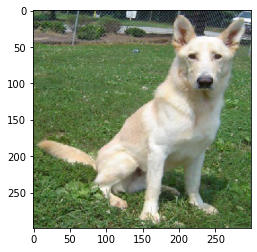

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.10774.jpg
predicted class:  778 , probability: 0.21379763
Top-5 predictions:
    Class Id Description  Probability (high to low)
0  n04141975       scale                   0.213798
1  n04554684      washer                   0.101448
2  n02123159   tiger_cat                   0.056938
3  n02123045       tabby                   0.043400
4  n04125021        safe                   0.042294


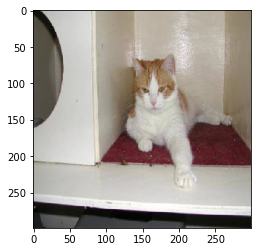

In [17]:
import random


image_files = get_image_files_from_dir(validation_dir, recursive=True)
# print (image_files)

for i in range(5):
    # get a random image
    index = random.randint(0, len(image_files)-1)
    image_file = image_files[index]
    predict_on_single_image(image_file, inceptionv3_model, tf.keras.applications.inception_v3)
    print ('============================================================================')
    

## Step 5 - Resnet Model

In [11]:
IMG_WIDTH=224
IMG_HEIGHT=224

from transfer_learning_utils import print_model_summary_compact

resnet152v2_model = tf.keras.applications.ResNet152V2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), 
                                               include_top = True,
                                               weights = 'imagenet')
print_model_summary_compact(resnet152v2_model)

* Model: "resnet152v2"
* Total params: 60,380,648
* Trainable params: 60,236,904
* Non-trainable params: 143,744
* # layers:  566


image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/cat/cat.1065.jpg
predicted class:  282 , probability: 0.7739263
Top-5 predictions:
    Class Id   Description  Probability (high to low)
0  n02123159     tiger_cat                   0.773926
1  n02123045         tabby                   0.144332
2  n02124075  Egyptian_cat                   0.074148
3  n04033995         quilt                   0.001469
4  n04344873  studio_couch                   0.001247


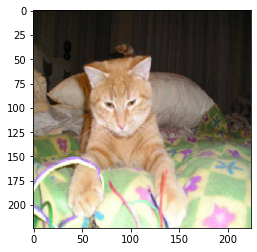

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.5315.jpg
predicted class:  39 , probability: 0.49395263
Top-5 predictions:
    Class Id            Description  Probability (high to low)
0  n01677366          common_iguana                   0.493953
1  n02483708                siamang                   0.325850
2  n02099267  flat-coated_retriever                   0.060503
3  n02105056            groenendael                   0.038212
4  n02444819                  otter                   0.024526


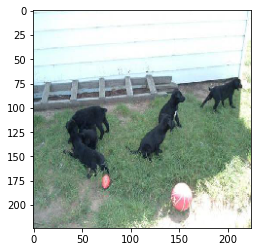

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.856.jpg
predicted class:  164 , probability: 0.5088524
Top-5 predictions:
    Class Id                  Description  Probability (high to low)
0  n02088632                     bluetick                   0.508852
1  n02105412                       kelpie                   0.221793
2  n02100236  German_short-haired_pointer                   0.088231
3  n02096585                  Boston_bull                   0.058937
4  n02106166                Border_collie                   0.040515


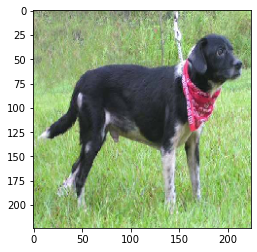

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.4972.jpg
predicted class:  182 , probability: 0.5582347
Top-5 predictions:
    Class Id                Description  Probability (high to low)
0  n02093754             Border_terrier                   0.558235
1  n02105162                   malinois                   0.283947
2  n02093256  Staffordshire_bullterrier                   0.048779
3  n02085620                  Chihuahua                   0.038280
4  n02113978           Mexican_hairless                   0.020644


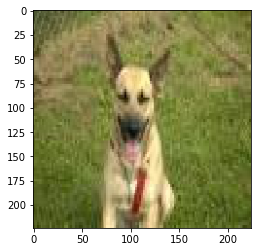

image_file: /home/sujee/.keras/datasets/cat-dog-redux/val/dog/dog.2809.jpg
predicted class:  164 , probability: 0.99999905
Top-5 predictions:
    Class Id                  Description  Probability (high to low)
0  n02088632                     bluetick               9.999990e-01
1  n02100735               English_setter               4.659589e-07
2  n02088238                       basset               3.965891e-07
3  n02100236  German_short-haired_pointer               9.716999e-08
4  n02102318               cocker_spaniel               4.062230e-08


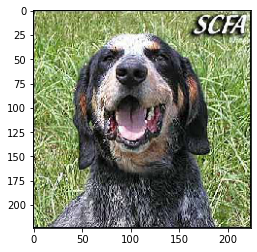

In [12]:
import random


image_files = get_image_files_from_dir(validation_dir, recursive=True)
# print (image_files)

for i in range(5):
    # get a random image
    index = random.randint(0, len(image_files)-1)
    image_file = image_files[index]
    predict_on_single_image(image_file, resnet152v2_model, tf.keras.applications.resnet_v2)
    print ('============================================================================')
    